In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import ndimage

plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = 3.0
plt.rcParams['legend.handlelength'] = 5.0

# Load Data

In [2]:
path = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/'

masks_path = []
images_path = []

for folder in os.listdir(path):
    if os.path.isdir(os.path.join(path,folder)):
        for folder2 in os.listdir(path+folder):
            if 'GT' in folder2 :
                for img in os.listdir(os.path.join(path,folder,folder2)):
                    masks_path.append(os.path.join(path,folder,folder2,img))
            else:
                for img in os.listdir(os.path.join(path,folder,folder2)):
                    images_path.append(os.path.join(path,folder,folder2,img))
                


data = {'images_path': images_path, 'masks_path': masks_path}

dataframe = pd.DataFrame(data)

In [3]:
dataframe.head()

,images_path,masks_path
0,../input/a-large-scale-fish-dataset/Fish_Datas...,../input/a-large-scale-fish-dataset/Fish_Datas...
1,../input/a-large-scale-fish-dataset/Fish_Datas...,../input/a-large-scale-fish-dataset/Fish_Datas...
2,../input/a-large-scale-fish-dataset/Fish_Datas...,../input/a-large-scale-fish-dataset/Fish_Datas...
3,../input/a-large-scale-fish-dataset/Fish_Datas...,../input/a-large-scale-fish-dataset/Fish_Datas...
4,../input/a-large-scale-fish-dataset/Fish_Datas...,../input/a-large-scale-fish-dataset/Fish_Datas...


In [4]:
MASK_WIDTH = 28
MASK_HEIGTH = 28

IMG_WIDTH = 128
IMG_HEIGTH = 128

images = []
masks = []

for path_image, path_mask in dataframe.values:
    img = cv2.imread(path_image)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGTH))
    images.append(img)
    
    mask = cv2.imread(path_mask,0)
    mask = cv2.resize(mask,(MASK_WIDTH,MASK_HEIGTH))
    masks.append(mask)
    
    
images = np.array(images)
masks = np.array(masks)

## Example of Image and Mask

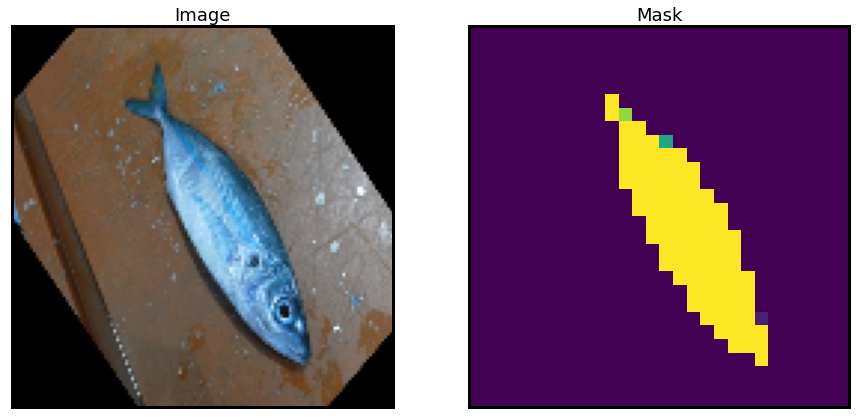

In [5]:
f, ax = plt.subplots(1,2, figsize=(15,9))

ax[0].imshow(images[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(masks[0])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Mask')

plt.show()

# PCA Rotation

## How PCA works?

PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on...

Knowing this, it is possbile two find two principal components that can explain the direction of the variance from the image masks, therefore we can find the angle between these components and rotate the image.

First lets take a sample from the dataframe

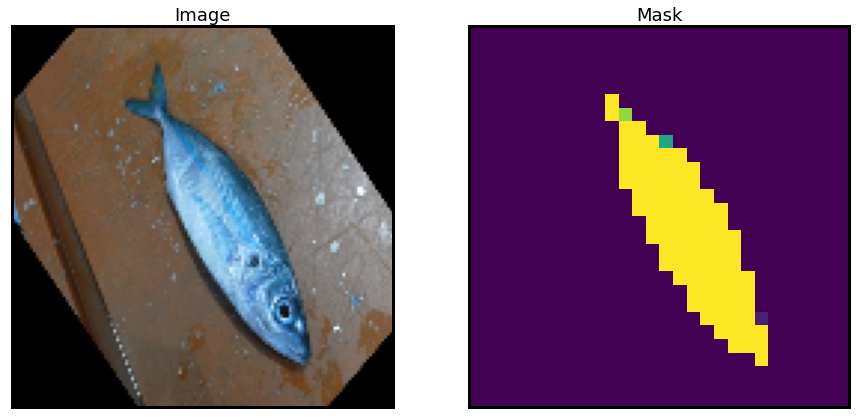

In [6]:
sample=0

f, ax = plt.subplots(1,2, figsize=(15,9))

ax[0].imshow(images[sample])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(masks[sample])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Mask')

plt.show()

Next, we need to find where the mask pixels are on X and Y coordinates

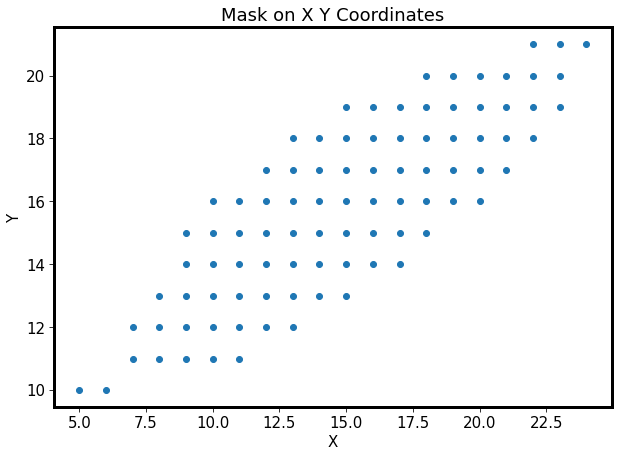

In [7]:
c, r = np.where(masks[sample]==255)

plt.figure(figsize=(10,7))
plt.scatter(c, r)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mask on X Y Coordinates')
plt.show()

Now we can prepare our data for input as follows

$
X = \begin{bmatrix}
c_{1} & r_{1} \\
c_{2} & r_{2} \\
\vdots & \vdots \\
c_{N} & r_{N}
\end{bmatrix}$

where c, r, and N represent column, row, and the total number of 1-valued pixels, respectively.

In [8]:
X = np.array([c,r]).T

For the PCA computation, remember to use 2 components

In [9]:
pca = PCA(n_components=2)

projected = pca.fit_transform(X)

We can visualize the direction of the principal components

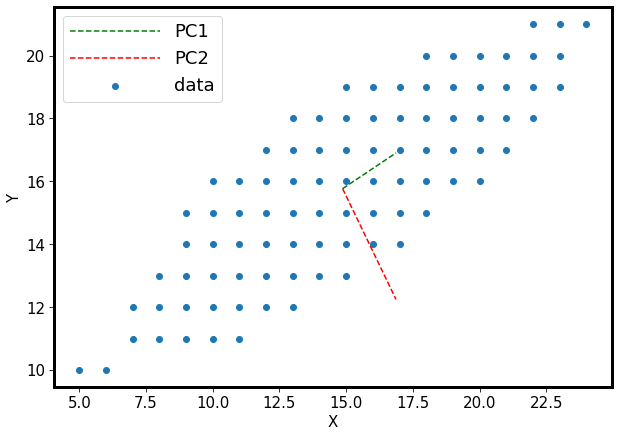

In [10]:
steps = np.linspace(0,2,10)

component_1_line = (pca.components_[1,0]/pca.components_[0,0]) * steps 
component_2_line = (pca.components_[1,1]/pca.components_[0,1]) * steps

plt.figure(figsize=(10,7))
plt.scatter(c, r, label='data')
plt.plot(steps + np.mean(c),component_1_line + np.mean(r),'g--', label='PC1')
plt.plot(steps + np.mean(c),component_2_line + np.mean(r),'r--', label='PC2')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

and the projected mask

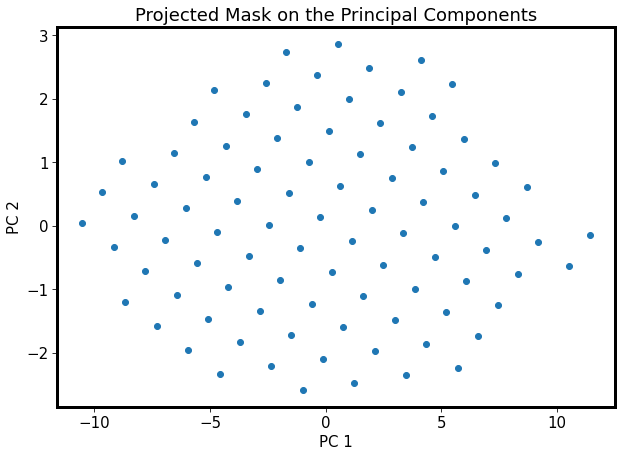

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(projected[:,0],projected[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Projected Mask on the Principal Components')
plt.show()

Now we find the angle of the image based on the principal components, and rotate the image back to center

In [12]:
angle = np.arctan2(pca.components_[0,1], pca.components_[0,0])
angle = np.degrees(angle)

rotated = ndimage.rotate(images[sample], -angle)

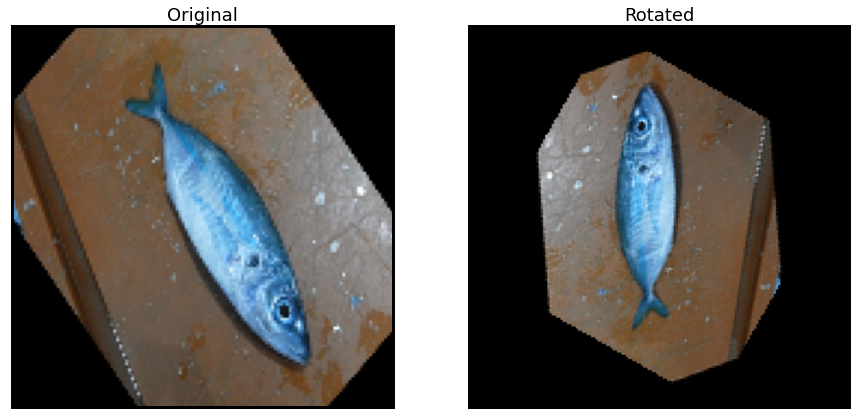

In [13]:
f, ax = plt.subplots(1,2, figsize=(15,9))

ax[0].imshow(images[sample])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original')

ax[1].imshow(rotated)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Rotated')

plt.show()

Encapsulating all in a function

In [14]:
def rotate_PCA(image, mask):

    c, r = np.where(mask==255)
    X = np.array([c,r]).T
    pca = PCA(n_components=2)
    projected = pca.fit_transform(X)
    angle = np.arctan2(pca.components_[0,1], pca.components_[0,0])
    angle = np.degrees(angle)
    rotated = ndimage.rotate(image, -angle)
    
    f, ax = plt.subplots(1,2, figsize=(15,9))

    ax[0].imshow(images[sample])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original')

    ax[1].imshow(rotated)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Rotated')

    plt.show()

# Results

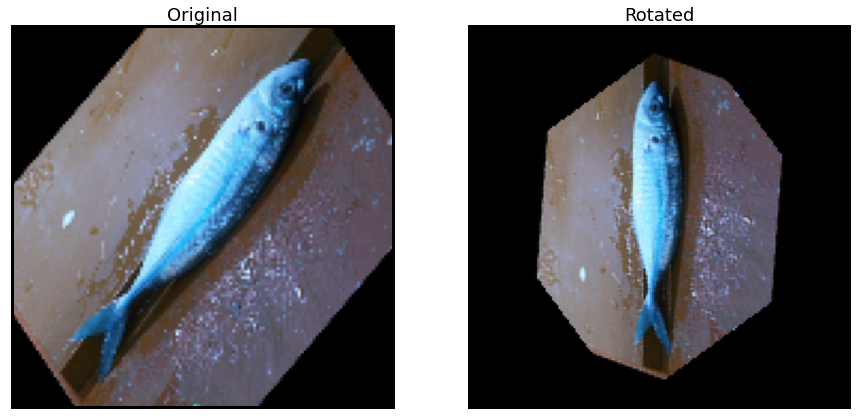

In [15]:
sample = 42
rotate_PCA(images[sample],masks[sample])

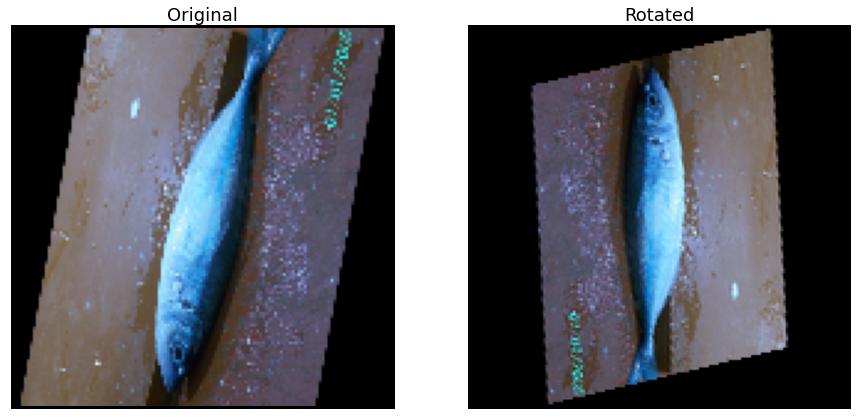

In [16]:
sample = 69
rotate_PCA(images[sample],masks[sample])

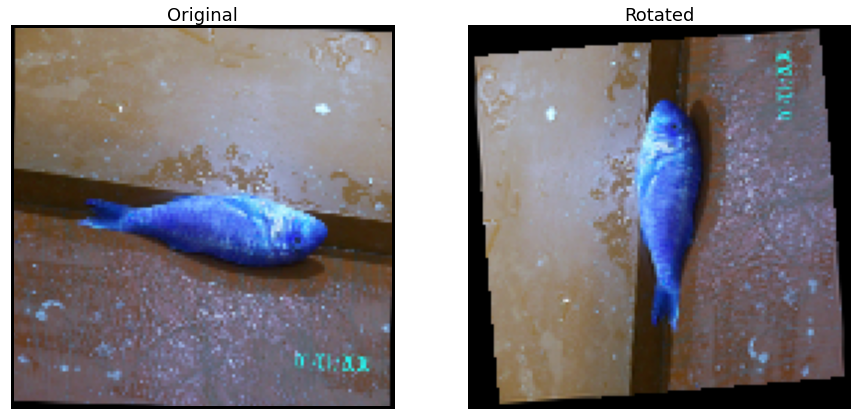

In [17]:
sample = 3450
rotate_PCA(images[sample],masks[sample])

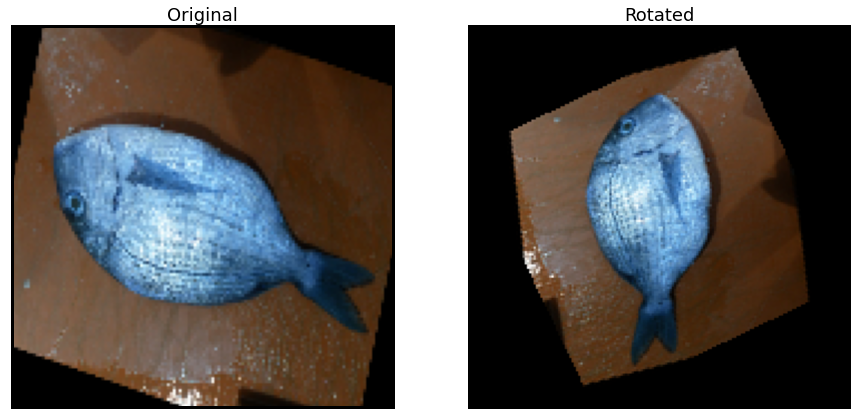

In [18]:
sample = 8050
rotate_PCA(images[sample],masks[sample])

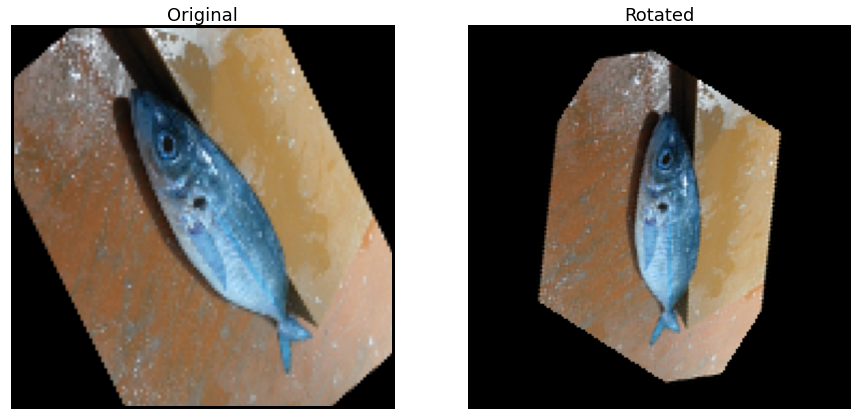

In [19]:
sample = 586
rotate_PCA(images[sample],masks[sample])